In [1]:
#import necessary packages
import os

import numpy as np
import random
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

use_cuda = True

In [25]:
#function to plot results

def plot_fit_history(history_plt):
  tr_acc = history_plt['acc']
  val_acc = history_plt['val_acc']
  tr_loss = history_plt['loss']
  val_loss = history_plt['val_loss']
  epochs_range = range(1, len(tr_acc) + 1)
  fig, ax1 = plt.subplots()

  color = 'tab:red'
  ax1.set_xlabel('Epochs')
  ax1.set_ylabel('Loss', color=color)
  l1, = ax1.plot(epochs_range, tr_loss, 's:', color=color, label='Training Loss', markeredgewidth=1, fillstyle='none')
  l2, = ax1.plot(epochs_range, val_loss, 'o-', color=color, label='Validation Loss')
  ax1.tick_params(axis='y', labelcolor=color, grid_color=color, grid_linestyle=':')

  ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

  color = 'tab:blue'
  ax2.set_ylabel('Accuracy', color=color)  # we already handled the x-label with ax1
  l3, = ax2.plot(epochs_range, tr_acc, 's:', color=color, label='Training Acc', markeredgewidth=1, fillstyle='none')
  l4, = ax2.plot(epochs_range, val_acc, 'o-', color=color, label='Validation Acc')
  ax2.tick_params(axis='y', labelcolor=color, grid_color=color, grid_linestyle=':')

  fig.tight_layout()  # otherwise the right y-label is slightly clipped
  
  plt.legend((l1, l2, l3, l4), ('Training Loss', 'Validation Loss', 'Training Acc', 'Validation Acc'), loc=(1.2,0.5))
  plt.show()

In [4]:
class DataSet:
  def __init__(self, songs):
    # list of songs
    self.s = songs
    # number of notes in each song
    self.n_s = []
    for s0 in songs:
      self.n_s.append(s0.shape[0])
    self.n_s = np.array(self.n_s)
    # total number of notes in all songs
    self.n_t = self.n_s.sum()
    # number of songs
    self.n_n = len(self.s)
    # all nodes as one sequence
    self.orig_data = np.concatenate(self.s)

# list of all songs from the datafile
s = []

with open('/content/drive/My Drive/Colab Notebooks/music.txt') as fp:
  for cnt, line in enumerate(fp):
    s0 = np.fromstring(line, sep=" ", dtype=int)
    s.append(s0)

full_set = DataSet(s)

print(full_set.n_t)

print(full_set.orig_data.shape)

1553149
(1553149,)


In [5]:
#preprocessing

# class index to class label mapping
data_dict = np.unique(full_set.orig_data);

dim = len(data_dict)

# class label to class index mapping
label_to_int = dict((l, i) for i, l in enumerate(data_dict))

# one-hot encoding from class indices
def get_one_hot(targets, nb_classes):
    res = np.eye(nb_classes)[targets]
    return res.reshape(list(targets.shape)+[nb_classes])

# encoding full DataSet
# by adding new attributes to the data structure
full_set.int_s = []
full_set.one_hot_s = []
for s0 in full_set.s:
  int_tmp = np.array([label_to_int[l] for l in s0], dtype=int)
  # data as class indices
  full_set.int_s.append(int_tmp)
  # data as one-hot vectors
  full_set.one_hot_s.append(get_one_hot(int_tmp, dim))

print(full_set.one_hot_s[0].shape)

(1004, 89)


In [9]:
#740 songs in total. I have taken first 70 songs as validation set. The rest is training set

n_validation_songs = 70

val_d = DataSet(s[0:n_validation_songs])
val_d.int_s = full_set.int_s[0:n_validation_songs]
val_d.one_hot_s = full_set.one_hot_s[0:n_validation_songs]

tr_d =  DataSet(s[n_validation_songs:])
tr_d.int_s = full_set.int_s[n_validation_songs:]
tr_d.one_hot_s = full_set.one_hot_s[n_validation_songs:]

In [10]:
print(val_d.one_hot_s[0].shape)

(1004, 89)


In [11]:
batch = 64
timelapse = 32

def generator(data, b=batch, t=timelapse):
  n_t_p = data.n_t - data.n_n*(t+1)
  n_s_p = data.n_s - (t+1)
  while True:
    samples = np.zeros((b, t, dim))
    targets = np.zeros((b)) 
    for k in range (b):
      i = random.randrange(0, n_t_p)
      j = 0;
      while i >= n_s_p[j]:
         i -= n_s_p[j]
         j += 1
      samples[k] = data.one_hot_s[j][i:i+t]
      targets[k] = data.int_s[j][i+t]

    yield samples, targets

In [12]:
class Model(nn.Module):

    def __init__(self, input_dim, hidden_dim, batch_size, output_dim=1,
                    num_layers=2):
        super(Model, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.batch_size = batch_size
        self.output_dim = output_dim
        self.num_layers = num_layers
        self.hidden = self.init_hidden()

        # Define the LSTM layer
        self.lstm = nn.LSTM(self.input_dim, self.hidden_dim, self.num_layers)

        # Define the dense layer
        self.linear = nn.Linear(self.hidden_dim, output_dim)

    def init_hidden(self):
        # This is what we'll initialise our hidden state as
        return (torch.zeros(self.num_layers, self.batch_size, self.hidden_dim),
                torch.zeros(self.num_layers, self.batch_size, self.hidden_dim))

    def forward(self, input):
        lstm_out, self.hidden = self.lstm(input.view(-1, self.batch_size, self.input_dim))
        y_pred = self.linear(lstm_out[-1].view(self.batch_size, -1))
        return y_pred

In [14]:
sample_size = tr_d.n_t - timelapse*tr_d.n_n
val_size = val_d.n_t - timelapse*val_d.n_n

h_dim = 512
model = Model(dim, h_dim, batch, dim, 2)
if use_cuda and torch.cuda.is_available():
    model.cuda()

In [15]:
learning_rate = 0.001

loss_fn = nn.CrossEntropyLoss()
optimiser = optim.RMSprop(model.parameters(), lr=learning_rate)

In [16]:
hist = {"acc": [], "loss": [], "val_loss": [], "val_acc": []}


def train(num_epochs, tr_gen, val_gen):
  for t in range(num_epochs):
    correct = 0
    total = 0
    for b1 in range(0, sample_size, batch*timelapse):
      
      # Clear stored gradient
      model.zero_grad()
      optimiser.zero_grad()

      # Forward pass
      x_batch, y_batch = next(tr_gen)
      x_batch = torch.from_numpy(np.swapaxes(x_batch, 0, 1)).float()
      y_batch = torch.from_numpy(y_batch).long()
      if use_cuda and torch.cuda.is_available():
        x_batch = x_batch.cuda()
        y_batch = y_batch.cuda()
      y_pred = model(x_batch)
      _, predicted = torch.max(y_pred.data, 1)
      labels = y_batch
      correct += (predicted.cpu() == labels.cpu()).sum()
      total += labels.size(0)
      loss = loss_fn(y_pred, y_batch)
      if b1 == 0:
        # print(y_pred.shape)
        print("Epoch ", t, "Loss: ", loss.item())
      currloss = loss.item()

      # Backward pass
      loss.backward()

      # Update parameters
      optimiser.step()
    
    accuracy = 100 * correct.item() / total
    hist["loss"].append(currloss)
    hist["acc"].append(accuracy)
    print("acc: ", accuracy)

    # Validation
    correct = 0
    total = 0
    loss = 0
    n_b = 0
    with torch.no_grad():
      for b in range(0, val_size, batch*timelapse):
        x_batch, y_batch = next(val_gen)
        x_batch = torch.from_numpy(np.swapaxes(x_batch, 0, 1)).float()
        y_batch = torch.from_numpy(y_batch).long()
        if use_cuda and torch.cuda.is_available():
          x_batch = x_batch.cuda()
          y_batch = y_batch.cuda()
        y_pred = model(x_batch)
        _, predicted = torch.max(y_pred.data, 1)
        labels = y_batch
        correct += (predicted.cpu() == labels.cpu()).sum()
        total += labels.size(0)
        loss += loss_fn(y_pred, y_batch)
        n_b += 1
      accuracy = 100 * correct.item() / total
      loss = loss.item() / n_b 
    hist["val_loss"].append(loss)
    hist["val_acc"].append(accuracy)
    print("Val acc: ", accuracy, "Val loss: ", loss)

In [17]:
gen = generator(tr_d)
vgen = generator(val_d)

In [18]:
train(70, gen, vgen)

Epoch  0 Loss:  4.486732482910156
acc:  5.612864077669903
Val acc:  8.217592592592593 Val loss:  3.4305052580656827
Epoch  1 Loss:  3.2902989387512207
acc:  8.735696948682385
Val acc:  8.333333333333334 Val loss:  3.3085259331597223
Epoch  2 Loss:  3.340198040008545
acc:  10.58859223300971
Val acc:  9.895833333333334 Val loss:  3.209254229510272
Epoch  3 Loss:  3.2309963703155518
acc:  12.049237170596394
Val acc:  12.789351851851851 Val loss:  3.0996226557978876
Epoch  4 Loss:  3.2155022621154785
acc:  13.817614424410541
Val acc:  13.541666666666666 Val loss:  3.0718807644314237
Epoch  5 Loss:  3.0386295318603516
acc:  15.490638002773926
Val acc:  15.79861111111111 Val loss:  2.9984249538845487
Epoch  6 Loss:  3.073774576187134
acc:  17.209171289875172
Val acc:  16.666666666666668 Val loss:  2.944413361725984
Epoch  7 Loss:  2.7493607997894287
acc:  18.663314840499307
Val acc:  18.75 Val loss:  2.882831432201244
Epoch  8 Loss:  3.099919319152832
acc:  20.366678224687934
Val acc:  19.15

In [19]:
for param_group in optimiser.param_groups:
        param_group['lr'] = learning_rate/3
train(25, gen, vgen)

Epoch  0 Loss:  1.6171602010726929
acc:  46.40256588072122
Val acc:  26.21527777777778 Val loss:  2.677842034233941
Epoch  1 Loss:  1.9959187507629395
acc:  47.94122746185853
Val acc:  27.430555555555557 Val loss:  2.6459602073386863
Epoch  2 Loss:  1.9449491500854492
acc:  48.4006588072122
Val acc:  27.025462962962962 Val loss:  2.6864906593605324
Epoch  3 Loss:  2.172487497329712
acc:  49.15265256588072
Val acc:  26.5625 Val loss:  2.718414871780961
Epoch  4 Loss:  1.7262163162231445
acc:  49.39103675450763
Val acc:  24.65277777777778 Val loss:  2.7403872454607927
Epoch  5 Loss:  1.9733823537826538
acc:  49.538401525658806
Val acc:  27.141203703703702 Val loss:  2.6606032760054976
Epoch  6 Loss:  1.566831111907959
acc:  50.98170943134535
Val acc:  26.099537037037038 Val loss:  2.698256598578559
Epoch  7 Loss:  1.4857220649719238
acc:  50.749826629680996
Val acc:  25.17361111111111 Val loss:  2.73043371129919
Epoch  8 Loss:  1.987724781036377
acc:  50.754160887656035
Val acc:  25.5208

In [20]:
for param_group in optimiser.param_groups:
        param_group['lr'] = learning_rate/9
train(25, gen, vgen)

Epoch  0 Loss:  1.4713115692138672
acc:  54.89121012482663
Val acc:  25.05787037037037 Val loss:  2.7646860193323204
Epoch  1 Loss:  1.7947115898132324
acc:  55.79056865464632
Val acc:  26.96759259259259 Val loss:  2.757218254937066
Epoch  2 Loss:  1.6789382696151733
acc:  56.51655686546463
Val acc:  24.82638888888889 Val loss:  2.827924375180845
Epoch  3 Loss:  1.9045196771621704
acc:  56.47104715672677
Val acc:  26.21527777777778 Val loss:  2.7502254909939237
Epoch  4 Loss:  1.9677573442459106
acc:  56.54256241331484
Val acc:  24.421296296296298 Val loss:  2.805894074616609
Epoch  5 Loss:  1.857614517211914
acc:  56.89363730929265
Val acc:  25.17361111111111 Val loss:  2.795800950792101
Epoch  6 Loss:  1.7255651950836182
acc:  57.03450069348128
Val acc:  25.05787037037037 Val loss:  2.771717495388455
Epoch  7 Loss:  1.3904460668563843
acc:  57.212205270457694
Val acc:  25.34722222222222 Val loss:  2.767832155580874
Epoch  8 Loss:  1.7005895376205444
acc:  57.59578710124827
Val acc:  

In [21]:
for param_group in optimiser.param_groups:
        param_group['lr'] = learning_rate/27
train(25, gen, vgen)

Epoch  0 Loss:  1.224149227142334
acc:  59.957957697642165
Val acc:  26.041666666666668 Val loss:  2.825036790635851
Epoch  1 Loss:  1.577004313468933
acc:  59.895110957004164
Val acc:  22.974537037037038 Val loss:  2.8975923326280384
Epoch  2 Loss:  1.1712009906768799
acc:  60.56475381414702
Val acc:  24.94212962962963 Val loss:  2.854255958839699
Epoch  3 Loss:  1.6501201391220093
acc:  60.354542302357835
Val acc:  25.810185185185187 Val loss:  2.809581332736545
Epoch  4 Loss:  1.1823394298553467
acc:  60.029472954230236
Val acc:  25.462962962962962 Val loss:  2.878371909812645
Epoch  5 Loss:  1.098065972328186
acc:  60.44556171983356
Val acc:  24.421296296296298 Val loss:  2.9197334006980613
Epoch  6 Loss:  1.5745879411697388
acc:  60.01863730929265
Val acc:  24.65277777777778 Val loss:  2.8937564425998263
Epoch  7 Loss:  1.7328226566314697
acc:  59.81059292649098
Val acc:  24.131944444444443 Val loss:  2.8470993041992188
Epoch  8 Loss:  1.5062373876571655
acc:  60.36971220527046
Va

In [22]:
for param_group in optimiser.param_groups:
        param_group['lr'] = learning_rate/81
train(25, gen, vgen)

Epoch  0 Loss:  1.4912675619125366
acc:  61.299410540915396
Val acc:  24.131944444444443 Val loss:  2.9106597900390625
Epoch  1 Loss:  1.1745402812957764
acc:  60.90499306518724
Val acc:  23.66898148148148 Val loss:  2.9073339391637734
Epoch  2 Loss:  1.4072463512420654
acc:  61.75667475728155
Val acc:  24.016203703703702 Val loss:  2.919075859917535
Epoch  3 Loss:  1.3966612815856934
acc:  61.10870319001387
Val acc:  25.0 Val loss:  2.897308349609375
Epoch  4 Loss:  1.7927181720733643
acc:  61.28857489597781
Val acc:  26.38888888888889 Val loss:  2.8490733393916376
Epoch  5 Loss:  1.5717158317565918
acc:  61.479282246879336
Val acc:  22.28009259259259 Val loss:  2.9485722294560186
Epoch  6 Loss:  1.533569574356079
acc:  61.40126560332871
Val acc:  23.09027777777778 Val loss:  2.9318884390371815
Epoch  7 Loss:  1.505269169807434
acc:  60.96783980582524
Val acc:  24.363425925925927 Val loss:  2.9013629489474826
Epoch  8 Loss:  1.8773112297058105
acc:  61.323248959778084
Val acc:  24.479

In [23]:
for param_group in optimiser.param_groups:
        param_group['lr'] = learning_rate/243
train(25, gen, vgen)

Epoch  0 Loss:  1.4025541543960571
acc:  61.943047850208046
Val acc:  23.66898148148148 Val loss:  2.9543081212926796
Epoch  1 Loss:  1.3898346424102783
acc:  62.45882454923717
Val acc:  24.88425925925926 Val loss:  2.922266924822772
Epoch  2 Loss:  1.459537148475647
acc:  62.19010055478502
Val acc:  25.0 Val loss:  2.8463270399305554
Epoch  3 Loss:  1.5288784503936768
acc:  61.854195561719834
Val acc:  27.546296296296298 Val loss:  2.7869330512152777
Epoch  4 Loss:  1.5619250535964966
acc:  61.72633495145631
Val acc:  24.305555555555557 Val loss:  2.8652301364474826
Epoch  5 Loss:  1.637434720993042
acc:  61.557298890429955
Val acc:  24.94212962962963 Val loss:  2.860844647442853
Epoch  6 Loss:  1.5863864421844482
acc:  61.925710818307905
Val acc:  24.247685185185187 Val loss:  2.908507735640914
Epoch  7 Loss:  1.6919147968292236
acc:  61.69816227461858
Val acc:  25.868055555555557 Val loss:  2.8896574797453702
Epoch  8 Loss:  1.6949553489685059
acc:  62.155426490984745
Val acc:  22.9

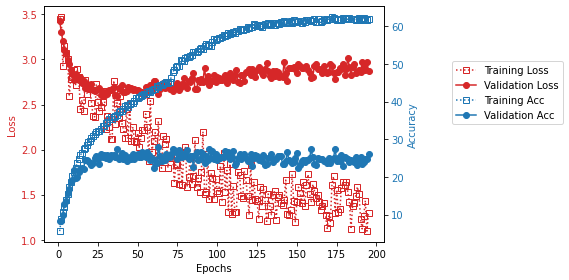

In [26]:
plot_fit_history(hist)
